In [5]:
!pip install open3d numpy matplotlib scipy scikit-learn


Defaulting to user installation because normal site-packages is not writeable


In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

from scipy.spatial import Delaunay
from scipy.interpolate import griddata  # For interpolation
from sklearn.neighbors import KDTree
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Loading DSM and Plane Data

In [7]:
try:
    with open("dsm.json") as f:
        dsm_data = np.array(json.load(f))
    print("DSM data successfully loaded.")
except FileNotFoundError:
    print("Error: DSM file not found.")
    exit()

try:
    with open("planes.json") as f:
        planes_data = json.load(f)
    print("Planes data successfully loaded.")
except FileNotFoundError:
    print("Error: Planes file not found.")
    exit()

DSM data successfully loaded.
Planes data successfully loaded.


## Creating Point Cloud

In [8]:
# Extracting (x, y, z) coordinates from DSM data
points = dsm_data[:, :3]

# Creating point cloud with Open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Assigning colors based on height (using viridis colormap)
colors = plt.cm.viridis(
    (points[:, 2] - points[:, 2].min()) / (points[:, 2].max() - points[:, 2].min())
)
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

## Processing Planes and Creating Meshes

In [9]:
meshes = []

for plane in planes_data:
    # Creating 3D coordinates from the perimeter
    perimeter = np.array(
        [[p['x'], p['y'], plane['height']] for p in plane['perimeter']]
    )

    # Adding noise to prevent errors with points lying on the same plane
    noise = np.random.normal(0, 1e-6, perimeter.shape)  # Small random noise
    perimeter_noisy = perimeter + noise

    # Creating Mesh with Delaunay triangulation
    tri = Delaunay(perimeter_noisy[:, :2])
    triangles = tri.simplices  # Obtain triangles

    # Creating mesh with Open3D
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(perimeter_noisy)
    mesh.triangles = o3d.utility.Vector3iVector(triangles)
    mesh.compute_vertex_normals()  # Computing surface normals
    meshes.append(mesh)


## Optional: 2D Scatter Plot Visualization

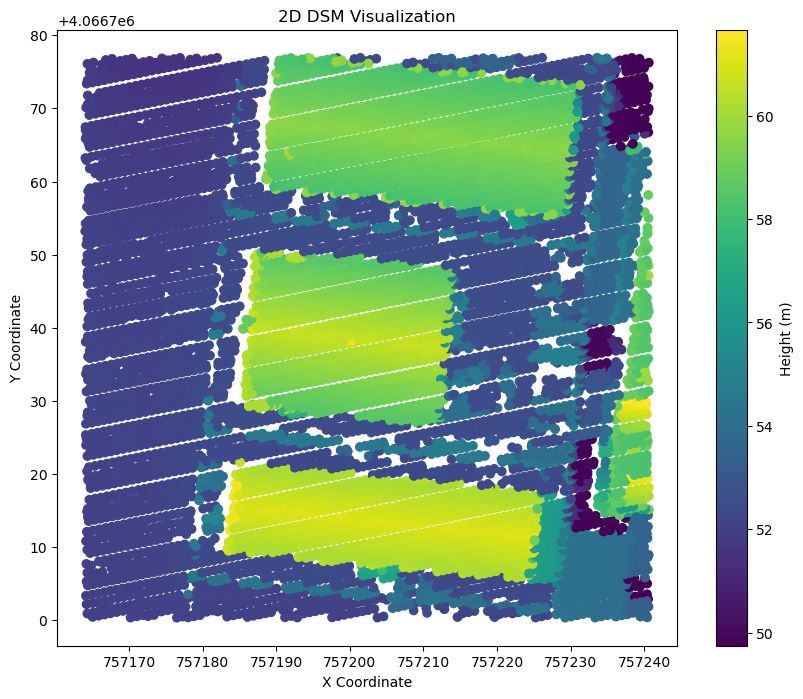

In [10]:
plt.figure(figsize=(10, 8))
plt.scatter(points[:, 0], points[:, 1], c=points[:, 2], cmap='viridis')
plt.colorbar(label='Height (m)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('2D DSM Visualization')
plt.show()